# Prova – Projetista de Sistemas Embarcados ML (Mobit)

- Q1: OpenCV (contagem por contornos)
- Q2.1: YOLOv8 (contagem de pessoas)
- Q2.2: Classificador BMW-10 (3,4,5 e Outros) com ResNet18

In [1]:
!pip -q install ultralytics opencv-python scipy scikit-learn matplotlib torch torchvision

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)
print("OK: deps + outputs/")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.9 MB/s eta 0:00:00
OK: deps + outputs/


In [2]:
Q1_IMAGE_PATH  = "/content/graos.jpg"       # imagem dos grãos
Q21_IMAGE_PATH = "/content/person.jpg"      # imagem pra YOLO (pessoas)

## Q1 — OpenCV (Contagem de objetos)

Objetos: 88


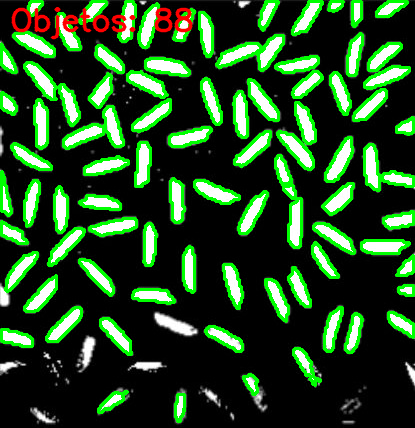

In [3]:
from google.colab.patches import cv2_imshow

# ============================================================
# CONTAGEM DE OBJETOS (GRÃOS) COM SEPARAÇÃO DE OBJETOS COLADOS
# Técnica: Threshold (OTSU) + Morfologia + Distance Transform + Watershed
# Depois: filtro por área e solidez para remover ruídos/artefatos.
# ============================================================

# ---------- 1) LEITURA DA IMAGEM ----------
img = cv2.imread(Q1_IMAGE_PATH)
if img is None:
    raise FileNotFoundError("Imagem não encontrada. Verifique o caminho em Q1_IMAGE_PATH.")

orig = img.copy()  # cópia para desenhar o resultado no final

# ---------- 2) PRÉ-PROCESSAMENTO (CINZA + SUAVIZAÇÃO) ----------
# Converte para tons de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Suaviza com Gaussiano para reduzir ruído antes do threshold
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# ---------- 3) BINARIZAÇÃO (THRESHOLD OTSU) ----------
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ---------- 4) LIMPEZA MORFOLÓGICA ----------
kernel = np.ones((3, 3), np.uint8)

# Opening: remove ruído
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Closing: fecha pequenos "buracos" nos grãos
opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)

# ---------- 5) PREPARAR PARA WATERSHED ----------
# sure_bg = fundo “com certeza”
# dilatação aumenta o fundo preto ao redor, ajudando a definir bordas
sure_bg = cv2.dilate(opening, kernel, iterations=2)

# distance transform: cria um "mapa" onde o centro do grão tem valor alto
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# sure_fg = “sementes” (núcleos) dos grãos
# fg_factor controla o quão “pequenas” são as sementes:
# - maior -> sementes menores (tende a separar melhor colados, mas pode perder alguns)
# - menor -> sementes maiores (tende a juntar colados)
fg_factor = 0.55
_, sure_fg = cv2.threshold(dist, fg_factor * dist.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)

# unknown = região que não sabemos se é fundo ou objeto
unknown = cv2.subtract(sure_bg, sure_fg)

# ---------- 6) MARCADORES PARA O WATERSHED ----------
# Rotula cada “semente” como um objeto diferente
num_labels, markers = cv2.connectedComponents(sure_fg)

# Ajustes exigidos pelo watershed:
# - fundo não pode ser 0 (o 0 é reservado para "unknown")
markers = markers + 1
markers[unknown == 255] = 0

# Watershed separa objetos colados com base nos marcadores
markers_ws = cv2.watershed(img, markers)
# Observação: watershed marca bordas com -1 (inclui borda externa da imagem)

# ---------- 7) FILTRO DOS SEGMENTOS (REMOVE SUJEIRA / ARTEFATOS) ----------
# Aqui filtramos os segmentos gerados pelo watershed:
# - área: remove pontinhos e coisas muito grandes
# - solidez: remove blobs “recortados”/irregulares (sujeira típica)

A_MIN   = 100
A_MAX   = 1300
SOL_MIN = 0.70

labels = np.unique(markers_ws)
valid_labels = []

for lab in labels:
    # lab <= 1:
    # -1 = borda watershed
    #  0 = unknown
    #  1 = fundo
    if lab <= 1:
        continue

    # máscara binária do segmento atual
    mask = (markers_ws == lab).astype(np.uint8) * 255

    # pega o contorno desse segmento
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        continue

    c = max(cnts, key=cv2.contourArea)

    # ---- filtro 1: área ----
    area = cv2.contourArea(c)
    if not (A_MIN <= area <= A_MAX):
        continue

    # ---- filtro 2: solidez ----
    # solidez = area / area_do_convex_hull
    # grão “bom” tende a ser mais “cheio”; sujeira irregular tende a ser menos sólida
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    if hull_area == 0:
        continue

    solidity = area / hull_area
    if solidity < SOL_MIN:
        continue

    valid_labels.append(lab)

print(f"Objetos: {len(valid_labels)}")

# ---------- 8) DESENHO DO RESULTADO FINAL ----------
out = orig.copy()

for lab in valid_labels:
    mask = (markers_ws == lab).astype(np.uint8) * 255
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(out, cnts, -1, (0, 255, 0), 2)

cv2.putText(out, f"Objetos: {len(valid_labels)}", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

cv2_imshow(out)

## Q2.1 — YOLOv8 (Contagem de pessoas)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Pessoas detectadas: 7


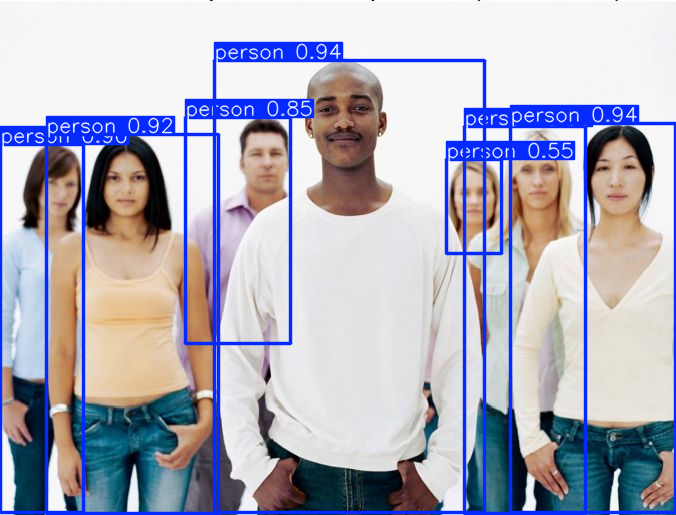

In [4]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# 1) Carregar o modelo pré-treinado (COCO)
model = YOLO("yolov8s.pt")

# 2) Ler a imagem
img = cv2.imread(Q21_IMAGE_PATH)
if img is None:
    raise FileNotFoundError("Não foi possível abrir 'person.jpg'. Verifique o nome/caminho.")

# 3) Inferência com model.predict()
# conf = limiar de confiança
results = model.predict(source=img, conf=0.40, iou=0.45, imgsz=640, verbose=False)

# 4) Contar quantas detecções são 'person'
# No COCO, 'person' é class_id = 0
r = results[0]
classes = r.boxes.cls.cpu().numpy().astype(int)  # array de class_ids
person_count = int(np.sum(classes == 0))

print(f"Pessoas detectadas: {person_count}")

# 5) Mostrar imagem anotada
annotated = r.plot()  # retorna imagem BGR com boxes/labels desenhados
cv2_imshow(annotated)

## Q2.2 — Classificador BMW-10 — Classificador 3/4/5 + Outros (Two-Stage)

Pipeline completo:
- Split recomendado pelo `.mat` (train/test)
- Val a partir do train (estratificado)
- **bbox crop** usando bboxes do `.mat`
- Abordagem para *Outros* com mais sentido: **2 estágios**
  1) Binário: `{3,4,5} vs Outros`
  2) 3-way: `3 vs 4 vs 5` (só se o estágio 1 aceitar)
- Saídas gráficas: curvas, histograma de confiança, matriz de confusão e métricas.

In [5]:
# =========================
# 0) CONFIGURAÇÕES
# =========================
TGZ_PATH = "/content/bmw10_release.tgz"
EXTRACT_DIR = "/mnt/data/bmw10_release"
MAT_PATH = f"{EXTRACT_DIR}/bmw10_annos.mat"
IMG_ROOT = f"{EXTRACT_DIR}/bmw10_ims"

SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32

EPOCHS_STAGE1 = 8     # {345} vs Outros
EPOCHS_STAGE2 = 8     # 3 vs 4 vs 5
LR_STAGE1 = 1e-3
LR_STAGE2 = 1e-4      # fine-tuning mais estável

T_OVR = 0.55          # limiar de rejeição -> Outros

CLASS_NAMES_4 = ["Classe_3", "Classe_4", "Classe_5", "Outros"]
CLASS_NAMES_3 = ["Classe_3", "Classe_4", "Classe_5"]


In [6]:
import os, tarfile, random
import numpy as np
import pandas as pd
import scipy.io
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [7]:
# =========================
# 1) EXTRAIR DATASET
# =========================
os.makedirs(EXTRACT_DIR, exist_ok=True)

if not os.path.exists(MAT_PATH):
    with tarfile.open(TGZ_PATH, "r:gz") as tar:
        tar.extractall(EXTRACT_DIR)

assert os.path.exists(MAT_PATH), "Arquivo .mat não encontrado após extração."
assert os.path.exists(IMG_ROOT), "Pasta de imagens não encontrada após extração."

print("OK:", MAT_PATH)
print("OK:", IMG_ROOT)


/tmp/ipython-input-2949730357.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(EXTRACT_DIR)


OK: /mnt/data/bmw10_release/bmw10_annos.mat
OK: /mnt/data/bmw10_release/bmw10_ims


In [8]:
# =========================
# 2) LER .MAT E MONTAR DATAFRAME
# =========================
mat = scipy.io.loadmat(MAT_PATH)

train_idx = mat["train_indices"].reshape(-1).astype(int) - 1  # 1-based -> 0-based
test_idx  = mat["test_indices"].reshape(-1).astype(int) - 1
annos     = mat["annos"][0]

def map_class_to_4(c_orig: int) -> int:
    # 0=classe3, 1=classe4, 2=classe5, 3=Outros
    if c_orig == 3: return 0
    if c_orig == 4: return 1
    if c_orig == 5: return 2
    return 3

rows = []
for i, a in enumerate(annos):
    fname = str(a["fname"][0])
    c_orig = int(a["class"][0][0])
    rows.append({
        "idx": i,
        "fname": fname,
        "class_orig": c_orig,
        "label4": map_class_to_4(c_orig),
        "x1": int(a["bbox_x1"][0][0]),
        "x2": int(a["bbox_x2"][0][0]),
        "y1": int(a["bbox_y1"][0][0]),
        "y2": int(a["bbox_y2"][0][0]),
    })

df = pd.DataFrame(rows)

df_train_full = df.iloc[train_idx].reset_index(drop=True)
df_test       = df.iloc[test_idx].reset_index(drop=True)

print("Train(full):", df_train_full.shape, "Test:", df_test.shape)
print("Distribuição Train(full) label4:")
display(df_train_full["label4"].value_counts().sort_index())


Train(full): (258, 8) Test: (254, 8)
Distribuição Train(full) label4:


,count
label4,
0,25
1,25
2,26
3,182


In [9]:
# =========================
# 3) SPLIT TREINO/VAL (DENTRO DO TRAIN DO .MAT)
# =========================
train_df, val_df = train_test_split(
    df_train_full,
    test_size=0.2,
    random_state=SEED,
    stratify=df_train_full["label4"]
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", train_df.shape, "Val:", val_df.shape)
print("Distribuição Train label4:")
display(train_df["label4"].value_counts().sort_index())
print("Distribuição Val label4:")
display(val_df["label4"].value_counts().sort_index())


Train: (206, 8) Val: (52, 8)
Distribuição Train label4:


,count
label4,
0,20
1,20
2,21
3,145


Distribuição Val label4:


,count
label4,
0,5
1,5
2,5
3,37


In [10]:
# =========================
# 4) DATASET (bbox crop)
# =========================
class BMW10Dataset(Dataset):
    def __init__(self, df, img_root, label_col, transform=None, use_bbox_crop=True):
        self.df = df
        self.img_root = img_root
        self.label_col = label_col
        self.transform = transform
        self.use_bbox_crop = use_bbox_crop

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img_path = os.path.join(self.img_root, row["fname"])
        img = Image.open(img_path).convert("RGB")

        if self.use_bbox_crop:
            x1, x2, y1, y2 = int(row["x1"]), int(row["x2"]), int(row["y1"]), int(row["y2"])
            x1 = max(0, x1); y1 = max(0, y1)
            x2 = min(img.width - 1, x2); y2 = min(img.height - 1, y2)
            if x2 > x1 and y2 > y1:
                img = img.crop((x1, y1, x2, y2))

        y = int(row[self.label_col])

        if self.transform:
            img = self.transform(img)

        return img, y


In [11]:
# =========================
# 5) TRANSFORMS
# =========================
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


In [12]:
# =========================
# 6) LABELS PARA 2 ESTÁGIOS
# =========================
# Estágio 1: 1 se é {3,4,5}, 0 se é Outros
for _df in (train_df, val_df, df_test):
    _df["label_ovr"] = (_df["label4"] != 3).astype(int)

# Estágio 2: somente {3,4,5}; label3 = 0/1/2 (já coincide com label4)
train_345 = train_df[train_df["label4"] != 3].copy().reset_index(drop=True)
val_345   = val_df[val_df["label4"] != 3].copy().reset_index(drop=True)
test_345  = df_test[df_test["label4"] != 3].copy().reset_index(drop=True)

train_345["label3"] = train_345["label4"]
val_345["label3"]   = val_345["label4"]
test_345["label3"]  = test_345["label4"]

print("Stage1 sizes:", len(train_df), len(val_df), len(df_test))
print("Stage2 sizes:", len(train_345), len(val_345), len(test_345))


Stage1 sizes: 206 52 254
Stage2 sizes: 61 15 76


In [13]:
# =========================
# 7) DATALOADERS (2 ESTÁGIOS)
# =========================
train_ds_ovr = BMW10Dataset(train_df, IMG_ROOT, "label_ovr", transform=train_tf, use_bbox_crop=True)
val_ds_ovr   = BMW10Dataset(val_df,   IMG_ROOT, "label_ovr", transform=eval_tf,  use_bbox_crop=True)
test_ds_4    = BMW10Dataset(df_test,  IMG_ROOT, "label4",    transform=eval_tf,  use_bbox_crop=True)

train_loader_ovr = DataLoader(train_ds_ovr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_ovr   = DataLoader(val_ds_ovr,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_4    = DataLoader(test_ds_4,    batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

train_ds_345 = BMW10Dataset(train_345, IMG_ROOT, "label3", transform=train_tf, use_bbox_crop=True)
val_ds_345   = BMW10Dataset(val_345,   IMG_ROOT, "label3", transform=eval_tf,  use_bbox_crop=True)

train_loader_345 = DataLoader(train_ds_345, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_345   = DataLoader(val_ds_345,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [14]:
# =========================
# 8) MODELOS: EfficientNet-B0
# =========================
def build_efficientnet_b0(num_classes: int):
    m = torchvision.models.efficientnet_b0(
        weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
    )
    in_features = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_features, num_classes)
    return m

model_ovr = build_efficientnet_b0(2).to(device)
model_345 = build_efficientnet_b0(3).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 54.4MB/s]


In [15]:
# =========================
# 9) LOSS + CLASS WEIGHTS
# =========================
# Stage1: binário (muito desbalanceado)
pos = train_df["label_ovr"].sum()
neg = len(train_df) - pos
w_pos = neg / (pos + 1e-9)  # peso para classe 1 (ser {3,4,5})
w_ovr = torch.tensor([1.0, w_pos], dtype=torch.float32).to(device)
criterion_ovr = nn.CrossEntropyLoss(weight=w_ovr)

# Stage2: 3-way (dê mais peso para Classe_5 para aumentar recall)
# labels: 0=Classe_3, 1=Classe_4, 2=Classe_5
w_345 = torch.tensor([1.0, 1.0, 1.7], dtype=torch.float32).to(device)
criterion_345 = nn.CrossEntropyLoss(weight=w_345)

optimizer_ovr = torch.optim.Adam(model_ovr.parameters(), lr=LR_STAGE1)
# Stage2 com LR menor + weight_decay (mais estável, menos overfit)
optimizer_345 = torch.optim.Adam(model_345.parameters(), lr=LR_STAGE2, weight_decay=1e-4)

print("Stage1 weights:", w_ovr.detach().cpu().numpy())
print("Stage2 weights:", w_345.detach().cpu().numpy())


Stage1 weights: [          1       2.377]
Stage2 weights: [          1           1         1.7]


In [16]:
# =========================
# 10) TREINO COM EARLY STOPPING
# =========================
def run_epoch(model, loader, criterion, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if training:
            optimizer.zero_grad()

        with torch.set_grad_enabled(training):
            logits = model(x)
            loss = criterion(logits, y)
            if training:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                              epochs, save_path, patience=3):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val = float("inf")
    bad = 0

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader, criterion, optimizer=None)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(f"Epoch {ep:02d}/{epochs} | train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
              f"val_loss={va_loss:.4f} acc={va_acc:.3f}")

        if va_loss < best_val:
            best_val = va_loss
            bad = 0
            torch.save(model.state_dict(), save_path)
        else:
            bad += 1
            if bad >= patience:
                print(f"Early stopping (patience={patience}).")
                break

    model.load_state_dict(torch.load(save_path, map_location=device))
    return history


def plot_history(history, title_prefix=""):
    plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 01/8 | train_loss=0.5969 acc=0.714 | val_loss=0.5684 acc=0.577
Epoch 02/8 | train_loss=0.2403 acc=0.859 | val_loss=1.1767 acc=0.788
Epoch 03/8 | train_loss=0.0644 acc=0.995 | val_loss=0.4195 acc=0.942
Epoch 04/8 | train_loss=0.0255 acc=0.990 | val_loss=0.3808 acc=0.962
Epoch 05/8 | train_loss=0.0956 acc=0.971 | val_loss=0.6095 acc=0.885
Epoch 06/8 | train_loss=0.1120 acc=0.961 | val_loss=0.3140 acc=0.942
Epoch 07/8 | train_loss=0.1031 acc=0.956 | val_loss=0.6590 acc=0.846
Epoch 08/8 | train_loss=0.1261 acc=0.947 | val_loss=0.5706 acc=0.904


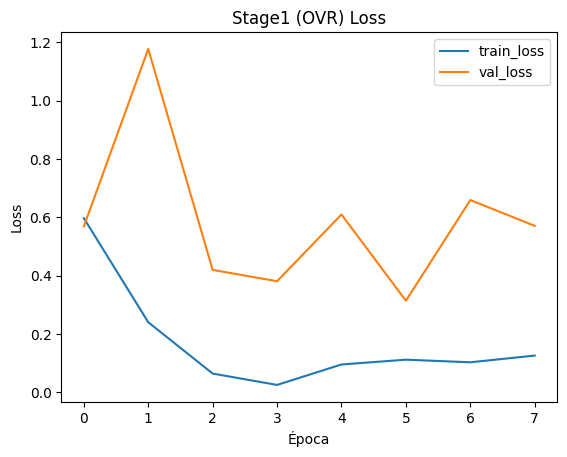

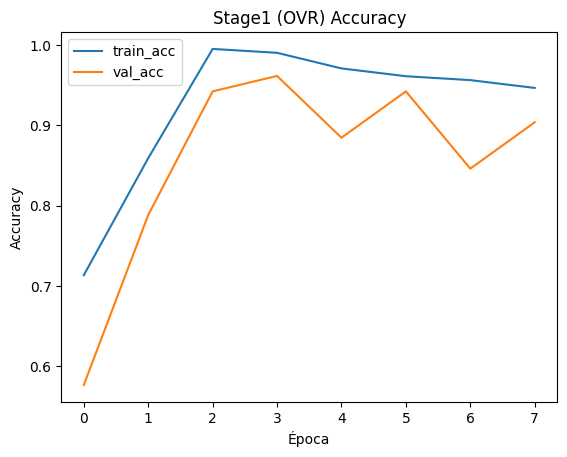

In [17]:
# =========================
# 11) TREINAR STAGE 1 (OVR)
# =========================
best_path_ovr = "/mnt/data/best_stage1_ovr.pth"
hist_ovr = train_with_early_stopping(
    model_ovr, train_loader_ovr, val_loader_ovr,
    criterion_ovr, optimizer_ovr,
    epochs=EPOCHS_STAGE1, save_path=best_path_ovr, patience=3
)
plot_history(hist_ovr, "Stage1 (OVR)")


Epoch 01/8 | train_loss=1.1264 acc=0.246 | val_loss=1.0818 acc=0.400
Epoch 02/8 | train_loss=1.0026 acc=0.557 | val_loss=1.0537 acc=0.467
Epoch 03/8 | train_loss=0.9179 acc=0.656 | val_loss=1.0251 acc=0.467
Epoch 04/8 | train_loss=0.8476 acc=0.836 | val_loss=0.9973 acc=0.533
Epoch 05/8 | train_loss=0.7427 acc=0.918 | val_loss=0.9698 acc=0.667
Epoch 06/8 | train_loss=0.6719 acc=0.934 | val_loss=0.9387 acc=0.667
Epoch 07/8 | train_loss=0.6125 acc=0.934 | val_loss=0.9088 acc=0.667
Epoch 08/8 | train_loss=0.5488 acc=0.984 | val_loss=0.8812 acc=0.667


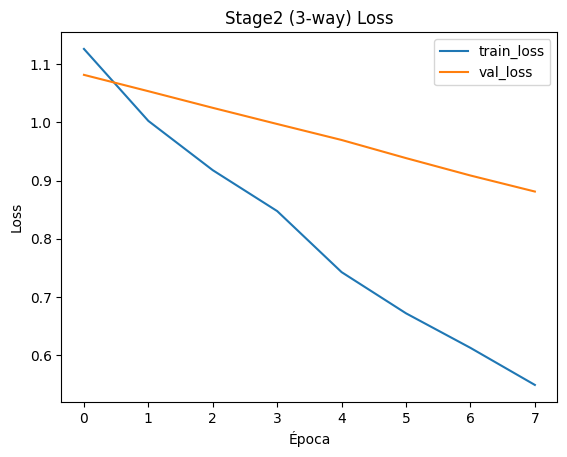

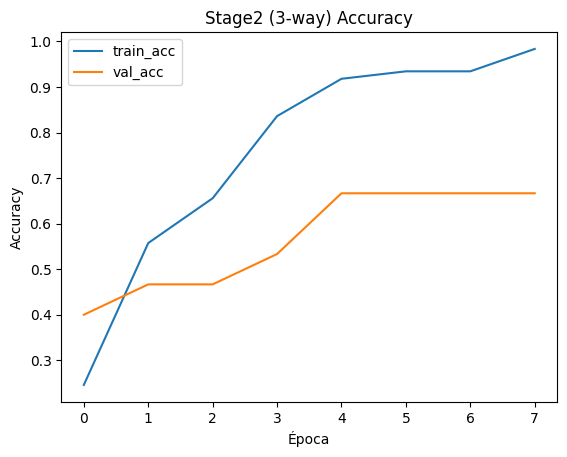

In [18]:
# =========================
# 12) TREINAR STAGE 2 (3-way)
# =========================
best_path_345 = "/mnt/data/best_stage2_345.pth"
hist_345 = train_with_early_stopping(
    model_345, train_loader_345, val_loader_345,
    criterion_345, optimizer_345,
    epochs=EPOCHS_STAGE2, save_path=best_path_345, patience=3
)
plot_history(hist_345, "Stage2 (3-way)")


In [19]:
# =========================
# 13) INFERÊNCIA 2 ESTÁGIOS + AVALIAÇÃO (4 classes)
# =========================
@torch.no_grad()
def predict_two_stage(x, T_ovr=0.55):
    model_ovr.eval()
    model_345.eval()

    logits_ovr = model_ovr(x)                 # [B,2]
    p345 = F.softmax(logits_ovr, dim=1)[:, 1] # prob "ser {3,4,5}"

    out = torch.full((x.size(0),), 3, device=x.device, dtype=torch.long)  # default Outros

    keep = p345 >= T_ovr
    if keep.any():
        logits_345 = model_345(x[keep])       # [b,3]
        pred_345 = logits_345.argmax(dim=1)   # 0,1,2
        out[keep] = pred_345

    return out, p345


@torch.no_grad()
def eval_two_stage(loader, T_ovr=0.55):
    y_true, y_pred, probs = [], [], []
    for x, y in loader:
        x = x.to(device)
        pred, p345 = predict_two_stage(x, T_ovr=T_ovr)
        y_true.append(y.numpy())
        y_pred.append(pred.cpu().numpy())
        probs.append(p345.cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(probs)


y_true, y_pred, p345 = eval_two_stage(test_loader_4, T_ovr=T_OVR)

print("Classification Report (4 classes):")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES_4, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])


Classification Report (4 classes):
              precision    recall  f1-score   support

    Classe_3     0.5455    0.4800    0.5106        25
    Classe_4     0.5789    0.4400    0.5000        25
    Classe_5     0.5000    0.4231    0.4583        26
      Outros     0.8429    0.9045    0.8726       178

    accuracy                         0.7677       254
   macro avg     0.6168    0.5619    0.5854       254
weighted avg     0.7526    0.7677    0.7579       254



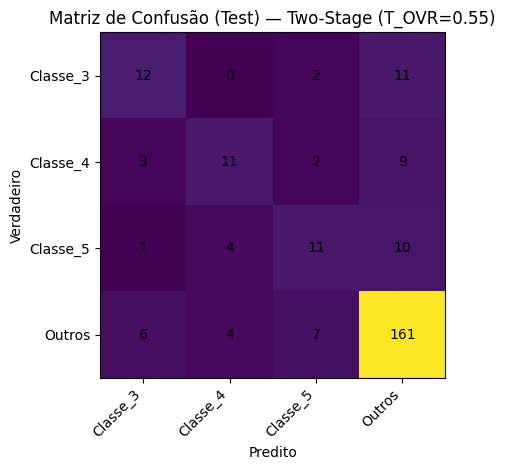

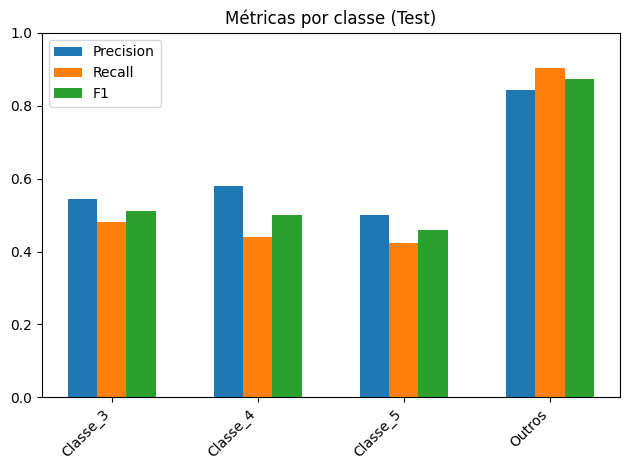

In [20]:
# =========================
# 14) MATRIZ DE CONFUSÃO + MÉTRICAS (GRÁFICOS)
# =========================
plt.figure()
plt.imshow(cm)
plt.title(f"Matriz de Confusão (Test) — Two-Stage (T_OVR={T_OVR})")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.xticks(range(len(CLASS_NAMES_4)), CLASS_NAMES_4, rotation=45, ha="right")
plt.yticks(range(len(CLASS_NAMES_4)), CLASS_NAMES_4)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

# Métricas derivadas do CM
eps = 1e-9
precision, recall, f1 = [], [], []
for k in range(cm.shape[0]):
    TP = cm[k, k]
    FP = cm[:, k].sum() - TP
    FN = cm[k, :].sum() - TP
    p = TP / (TP + FP + eps)
    r = TP / (TP + FN + eps)
    f = 2*p*r / (p + r + eps)
    precision.append(p); recall.append(r); f1.append(f)

x = np.arange(len(CLASS_NAMES_4))
plt.figure()
plt.bar(x - 0.2, precision, width=0.2, label="Precision")
plt.bar(x,       recall,    width=0.2, label="Recall")
plt.bar(x + 0.2, f1,        width=0.2, label="F1")
plt.xticks(x, CLASS_NAMES_4, rotation=45, ha="right")
plt.ylim(0, 1.0)
plt.title("Métricas por classe (Test)")
plt.legend()
plt.tight_layout()
plt.show()


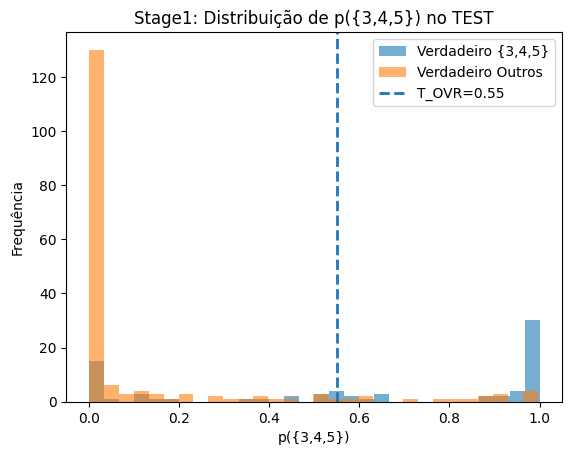

In [21]:
# =========================
# 15) GRÁFICO PARA DISCUSSÃO: HISTOGRAMA p({3,4,5})
# =========================
is_345_true = (y_true != 3)

plt.figure()
plt.hist(p345[is_345_true], bins=30, alpha=0.6, label="Verdadeiro {3,4,5}")
plt.hist(p345[~is_345_true], bins=30, alpha=0.6, label="Verdadeiro Outros")
plt.axvline(T_OVR, linestyle="--", linewidth=2, label=f"T_OVR={T_OVR}")
plt.title("Stage1: Distribuição de p({3,4,5}) no TEST")
plt.xlabel("p({3,4,5})")
plt.ylabel("Frequência")
plt.legend()
plt.show()


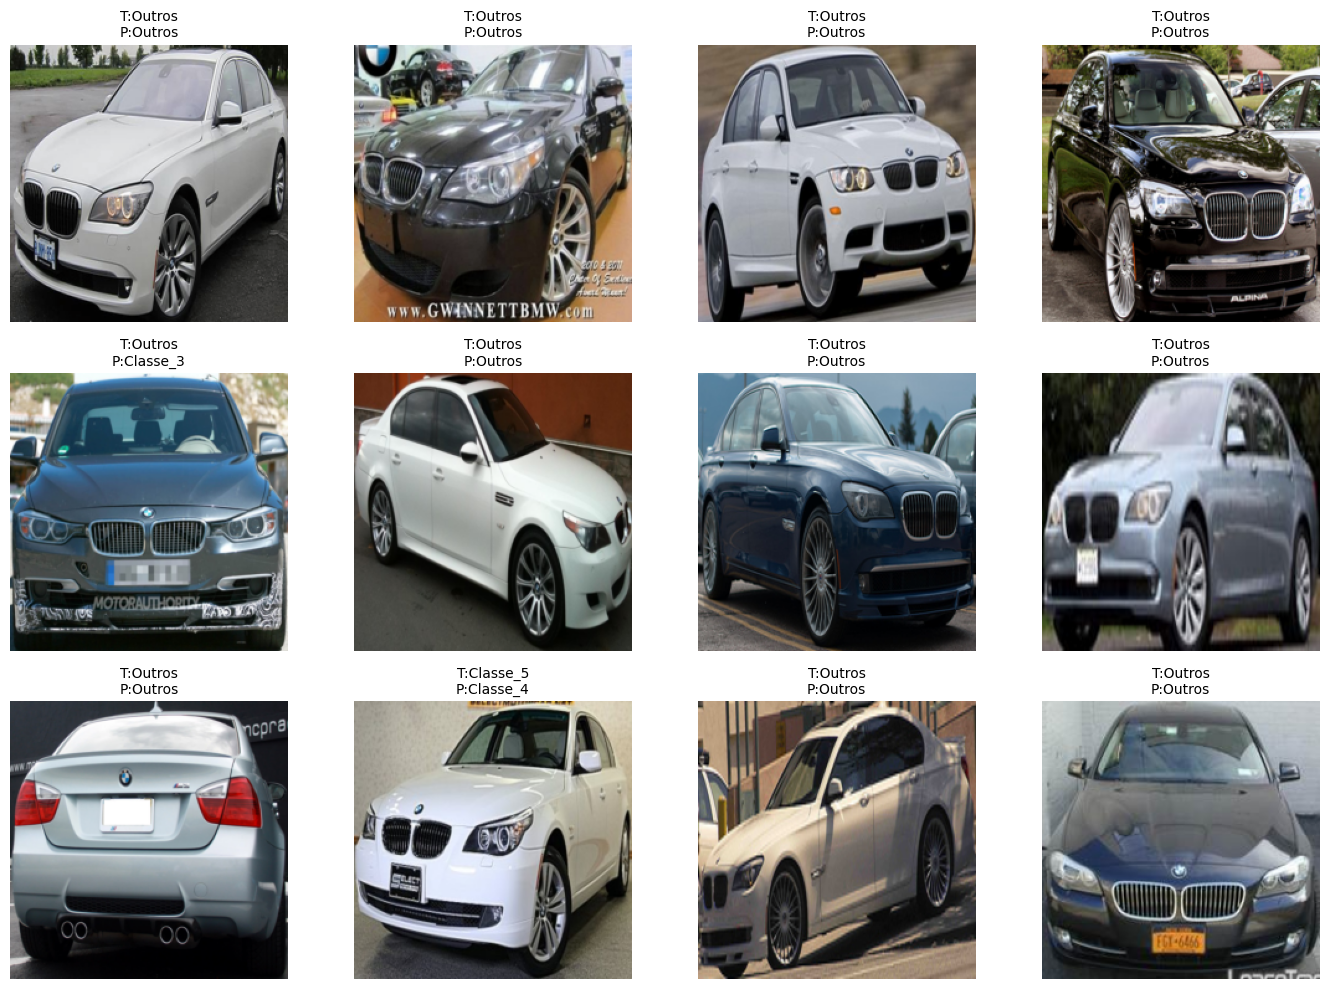

In [22]:
# =========================
# 16) (OPCIONAL) GRID DE AMOSTRAS (pred vs true)
# =========================
def denorm(img_t):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img = img_t.cpu() * std + mean
    img = (img.clamp(0,1).permute(1,2,0).numpy() * 255).astype(np.uint8)
    return img

vis_loader = DataLoader(test_ds_4, batch_size=12, shuffle=True)
x, y = next(iter(vis_loader))
x_dev = x.to(device)

pred, _ = predict_two_stage(x_dev, T_ovr=T_OVR)
pred = pred.cpu().numpy()
y = y.numpy()

fig = plt.figure(figsize=(14, 10))
for i in range(min(12, x.size(0))):
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(denorm(x[i]))
    ax.set_title(f"T:{CLASS_NAMES_4[y[i]]}\nP:{CLASS_NAMES_4[pred[i]]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()
